In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [21]:
# Load dataset
df = pd.read_csv("design_out.csv")
df.head()

,sigma_mem_y,f_mem,sigma_mem,E_mem,nu_mem,sigma_edg,sigma_sup,sigma_mem_max
0,10691.555444,0.268767,3220.880252,620830.965150,0.399472,325851.235578,322000.762345,4204.095289
1,10869.833243,0.511186,4603.969420,559505.773241,0.398297,266690.745363,366814.407254,5578.199692
2,9629.396012,0.316207,4020.464157,664063.602748,0.393333,350103.330214,308367.205040,4688.809620
3,12188.818172,0.457326,4282.802400,622714.404090,0.411230,313489.897816,327438.702828,5219.281260
4,11108.292227,0.261861,4097.033516,623600.545225,0.382459,334400.590712,474471.127871,4986.756515


In [22]:
# Split into features (X) and target (y)
X = df.iloc[:, :-1]  # all columns except last
y = df.iloc[:, -1]   # last column = response

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# print the features and response names 
print("Response name:", y.name)
print("Feature names:", X.columns.tolist())

Features shape: (200, 7)
Target shape: (200,)
Response name: sigma_mem_max
Feature names: ['sigma_mem_y', 'f_mem', 'sigma_mem', 'E_mem', 'nu_mem', 'sigma_edg', 'sigma_sup']


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1) SVR Model

In [25]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [26]:
# Build pipeline
pipeline = make_pipeline(StandardScaler(), SVR())

# Define search grid
param_grid = {
    "svr__C": [0.1, 1, 10, 100, 1000],
    "svr__epsilon": [0.001, 0.01, 0.1, 0.5, 1],
    "svr__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]
}

# Run grid search with 5-fold CV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best R2 Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)


Best R2 Score: 0.9905123232245847
Best Parameters: {'svr__C': 1000, 'svr__epsilon': 1, 'svr__gamma': 0.01}


In [27]:
# Build final SVR model with optimal hyperparameters
best_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1000, epsilon=1, gamma=0.01)
)

# Fit on the FULL dataset (not train/test split)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


In [28]:
# Training metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)



In [29]:
# Create datafram for errors storage with row names as model names and columns as Train and Test errors
errors_df = pd.DataFrame(
    data={
        "R2_Train": [r2_train],
        "R2_Test": [r2_test],
        "MSE_Train": [mse_train],
        "MSE_Test": [mse_test]
    },
    index=["SVR_Model"]
)

errors_df

,R2_Train,R2_Test,MSE_Train,MSE_Test
SVR_Model,0.99614,0.997061,807.373233,1082.919681


In [30]:
# Save the trained model
joblib.dump(best_model, "svr_sunsail_model.pkl")

# Import the trained model from above code
# best_model = joblib.load("svr_sunsail_model.pkl")

['svr_sunsail_model.pkl']

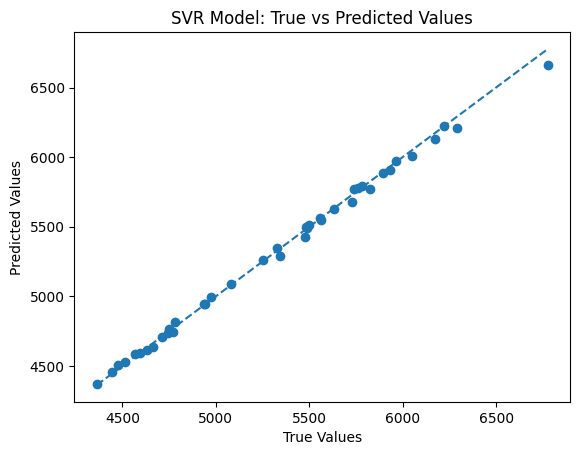

In [31]:
# Scatter plot of true vs predicted values
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], '--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("SVR Model: True vs Predicted Values")
plt.show()

## 2) Polynomial Regression 

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [33]:
# List of degrees to try
degrees = [1, 2, 3, 4, 5, 6]

best_degree = None
best_mse = float('inf')
mse_scores_per_degree = []

for degree in degrees:
    # Create pipeline: polynomial features + scaling + linear regression
    model = make_pipeline(
        PolynomialFeatures(degree=degree),
        StandardScaler(),
        LinearRegression()
    )
    
    # 5-fold cross-validation for MSE (negative because cross_val_score maximizes score)
    neg_mse_scores = cross_val_score(model, X_train, y_train, cv=5,
                                     scoring=make_scorer(mean_squared_error))
    mse_scores = neg_mse_scores.mean()  # Average MSE across folds
    mse_scores_per_degree.append(mse_scores)
    
    print(f"Degree {degree}: Mean 5-CV MSE = {mse_scores:.4f}")
    
    # Keep track of the best degree
    if mse_scores < best_mse:
        best_mse = mse_scores
        best_degree = degree

print(f"\nBest degree based on 5-CV MSE: {best_degree}")

# Fit final model with best degree on full training data
best_poly_model = make_pipeline(
    PolynomialFeatures(degree=best_degree),
    StandardScaler(),
    LinearRegression()
)

best_poly_model.fit(X_train, y_train)

# Predictions
y_train_pred = best_poly_model.predict(X_train)
y_test_pred = best_poly_model.predict(X_test)

# Training and test metrics

r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"\nTraining R²: {r2_train:.4f}, MSE: {mse_train:.4f}")
print(f"Test R²: {r2_test:.4f}, MSE: {mse_test:.4f}")


Degree 1: Mean 5-CV MSE = 3599.4556
Degree 2: Mean 5-CV MSE = 200.8980
Degree 3: Mean 5-CV MSE = 1223.2214
Degree 4: Mean 5-CV MSE = 402.4213
Degree 5: Mean 5-CV MSE = 402.7656
Degree 6: Mean 5-CV MSE = 480.0462

Best degree based on 5-CV MSE: 2

Training R²: 0.9995, MSE: 103.5665
Test R²: 0.9996, MSE: 129.8693


In [34]:
# Errors from Polynomial Regression
errors_df.loc["Polynomial_Regression"] = [r2_train, r2_test, mse_train, mse_test]

# Display updated DataFrame
print(errors_df)


                       R2_Train   R2_Test   MSE_Train     MSE_Test
SVR_Model              0.996140  0.997061  807.373233  1082.919681
Polynomial_Regression  0.999505  0.999647  103.566473   129.869288


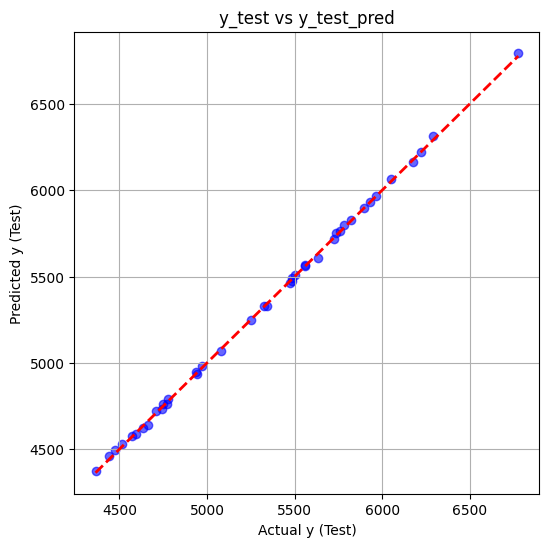

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual y (Test)")
plt.ylabel("Predicted y (Test)")
plt.title("y_test vs y_test_pred")
plt.grid(True)
plt.show()


## 3) GPR

In [36]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C




In [79]:

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define kernel: Constant * RBF
# You can tune length_scale
# kernel = C(1.0, (1e-3, 1e6)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))



kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-3, 1e2))





# kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, nu=1.5)

# Initialize Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# Fit model
gpr.fit(X_train_scaled, y_train)

print(gpr.kernel_)
# Predictions
y_train_pred, y_train_std = gpr.predict(X_train_scaled, return_std=True)
y_test_pred, y_test_std = gpr.predict(X_test_scaled, return_std=True)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Gaussian Process Regression -> Training R²: {r2_train:.4f}, MSE: {mse_train:.4f}")
print(f"Gaussian Process Regression -> Test R²: {r2_test:.4f}, MSE: {mse_test:.4f}")


6.4**2 * RBF(length_scale=16.3) + WhiteKernel(noise_level=0.001)
Gaussian Process Regression -> Training R²: 0.9996, MSE: 75.0583
Gaussian Process Regression -> Test R²: 0.9997, MSE: 99.9148


c:\Users\rahul\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [80]:
# Errors from Polynomial Regression
errors_df.loc["GPR"] = [r2_train, r2_test, mse_train, mse_test]

# Display updated DataFrame
print(errors_df)


                       R2_Train   R2_Test   MSE_Train     MSE_Test
SVR_Model              0.996140  0.997061  807.373233  1082.919681
Polynomial_Regression  0.999505  0.999647  103.566473   129.869288
GPR                    0.999641  0.999729   75.058345    99.914819


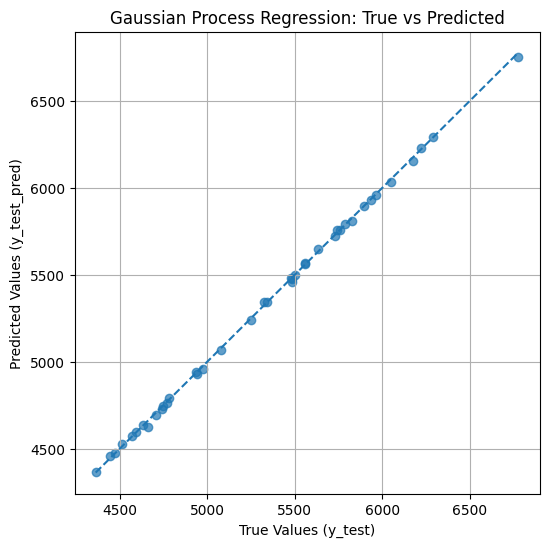

In [39]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         linestyle='--')
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_test_pred)")
plt.title("Gaussian Process Regression: True vs Predicted")
plt.grid(True)
plt.show()
